# Build RAG solution with LangChain and Amazon Bedrock using OpenSearch Serverless

This notebook provides sample code for building a RAG solution using LangChain and Amazon Bedrock using OpenSearch Serverless.

## Overview

In a RAG application, the vector store plays a crucial role in the retrieval step. When a user submits a query, the query is first converted into a vector representation using a pre-trained language model. The vector store is then searched for the most relevant documents or passages based on the similarity between their vectors and the query vector. The retrieved documents or passages are then used to generate the response.

In this sample we will use OpenSearch Serverless to build a vector store and then use it in a RAG application using LangChain. The vector search collection type in OpenSearch Serverless provides a similarity search capability that is scalable and high performing. It makes it easy for you to build modern machine learning (ML) augmented search experiences and generative artificial intelligence (AI) applications without having to manage the underlying vector database infrastructure.

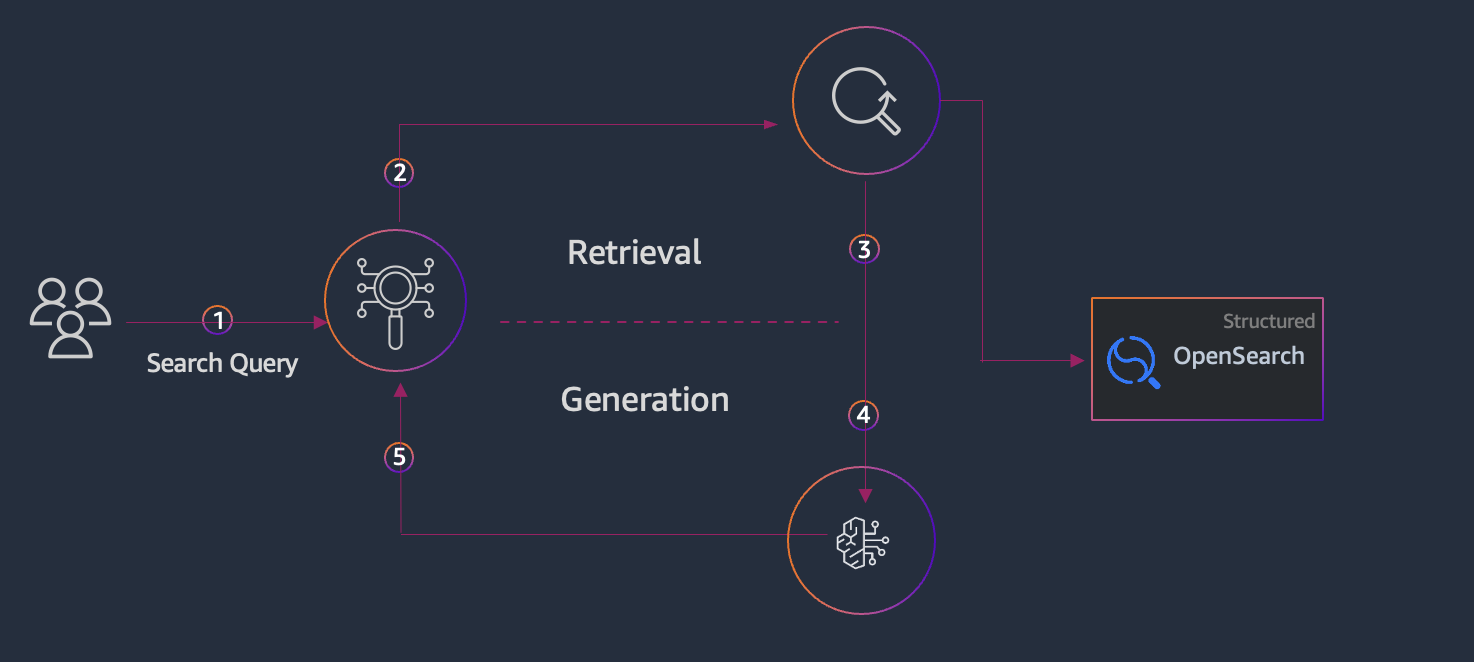


### Steps: 

1. Create necessary policies for Amazon OpenSearch Serverless
2. Create an OpenSearch Serverless cluster and deploy a vector store collection
3. Use the OpenSearch Serverless VectorStore as retriever in LangChain
4. Create generation pipeline using `create_stuff_documents_chain`
5. Use the pipeline to generate response for user queries





## Setup

Before running the rest of this notebook, you'll need to run the cells below to (ensure necessary libraries are installed and) connect to Bedrock.

In [21]:
%pip install -U opensearch-py==2.3.1 --quiet
%pip install -U boto3 --quiet
%pip install -U retrying==1.3.4 --quiet
%pip install --quiet langchain langchain-community langchain_aws bs4 pypdf
%pip install --quiet requests requests-aws4auth

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Create a vector store - OpenSearch Serverless index

First of all we have to create a vector store. In this section we will use Amazon OpenSearch serverless.

Amazon OpenSearch Serverless is a serverless option in Amazon OpenSearch Service. As a developer, you can use OpenSearch Serverless to run petabyte-scale workloads without configuring, managing, and scaling OpenSearch clusters. You get the same interactive millisecond response times as OpenSearch Service with the simplicity of a serverless environment. Pay only for what you use by automatically scaling resources to provide the right amount of capacity for your application—without impacting data ingestion.



In [6]:
import boto3
import pprint

boto3_session = boto3.session.Session()
region_name = boto3_session.region_name
service = "aoss"



In [3]:
vector_store_name = f'bedrock-sample-rag-oss'
index_name = f"bedrock-sample-rag-index-oss"
aoss_client = boto3_session.client('opensearchserverless')

pp = pprint.PrettyPrinter(indent=2)

This code creates three security policies for an Amazon OpenSearch Serverless collection using the. The policies include an encryption policy, a network policy, and an access policy. Here's a brief description of each policy:

**Encryption Policy:**

This policy specifies that Amazon OpenSearch Serverless should use an AWS-owned key for encrypting the data in the specified collection.
It grants the encryption permission for the specified collection.

**Network Policy:**

This policy allows public access to the specified collection.
It grants the network access permission for the specified collection.

**Access Policy:**

This policy grants permissions to the specified principal (the AWS identity executing the code) to perform various operations on the collection and its associated indexes.

For the collection, it grants permissions to create, delete, update, and describe collection items.
For the indexes associated with the collection, it grants permissions to create, delete, update, and describe indexes, as well as read and write documents.

<div class="alert alert-block alert-info">
<b>Note:</b> These policies are defined just to run this sample. Please make sure to define these policies based on your requirements and security best practices.
</div>

In [29]:
import json


identity = boto3.client("sts").get_caller_identity()["Arn"]

encryption_policy_name = f"bedrock-sample-rag-oss"
network_policy_name = f"bedrock-sample-rag-np-oss"
access_policy_name = f"bedrock-sample-rag-ap-oss"

def create_policies_in_oss(
    vector_store_name, aoss_client
):
    encryption_policy = aoss_client.create_security_policy(
        name=encryption_policy_name,
        policy=json.dumps(
            {
                "Rules": [
                    {
                        "Resource": ["collection/" + vector_store_name],
                        "ResourceType": "collection",
                    }
                ],
                "AWSOwnedKey": True,
            }
        ),
        type="encryption",
    )

    network_policy = aoss_client.create_security_policy(
        name=network_policy_name,
        policy=json.dumps(
            [
                {
                    "Rules": [
                        {
                            "Resource": ["collection/" + vector_store_name],
                            "ResourceType": "collection",
                        }
                    ],
                    "AllowFromPublic": True,
                }
            ]
        ),
        type="network",
    )
    access_policy = aoss_client.create_access_policy(
        name=access_policy_name,
        policy=json.dumps(
            [
                {
                    "Rules": [
                        {
                            "Resource": ["collection/" + vector_store_name],
                            "Permission": [
                                "aoss:CreateCollectionItems",
                                "aoss:DeleteCollectionItems",
                                "aoss:UpdateCollectionItems",
                                "aoss:DescribeCollectionItems",
                            ],
                            "ResourceType": "collection",
                        },
                        {
                            "Resource": ["index/" + vector_store_name + "/*"],
                            "Permission": [
                                "aoss:CreateIndex",
                                "aoss:DeleteIndex",
                                "aoss:UpdateIndex",
                                "aoss:DescribeIndex",
                                "aoss:ReadDocument",
                                "aoss:WriteDocument",
                            ],
                            "ResourceType": "index",
                        },
                    ],
                    "Principal": [identity],
                    "Description": "Easy data policy",
                }
            ]
        ),
        type="data",
    )
    return encryption_policy, network_policy, access_policy

This code creates a new Amazon OpenSearch Serverless collection with the specified `vector_store_name` and applies the previously created security policies to it.

In [8]:
encryption_policy, network_policy, access_policy = create_policies_in_oss(
    vector_store_name=vector_store_name,
    aoss_client=aoss_client,
)
collection = aoss_client.create_collection(name=vector_store_name, type="VECTORSEARCH")

In [9]:
collection_id = collection["createCollectionDetail"]["id"]
collection_id = collection["createCollectionDetail"]["id"]
host = collection_id + "." + region_name + ".aoss.amazonaws.com"
print(host)

7p2nmbgokp3l2ngnkrkf.us-east-1.aoss.amazonaws.com


In [25]:
host = "7p2nmbgokp3l2ngnkrkf.us-east-1.aoss.amazonaws.com"

In [26]:
import time

def interactive_sleep(seconds: int):
    dots = ""
    for i in range(seconds):
        dots += "."
        print(dots, end="\r")
        time.sleep(1)
    print("Done!")

Let's setup an OpenSearch index with a vector field for similarity search using the k-Nearest Neighbors (KNN) algorithm.

**Different embeddings models may have different output dimensions, and the dimension value in the mappings should be adjusted accordingly.**

In this sample we are using `amazon.titan-embed-text-v2:0`, which has an output dimension of 1024.

In [64]:
# Create the vector index in Opensearch serverless, with the knn_vector field index mapping, specifying the dimension size, name and engine.
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth, RequestError
credentials = boto3.Session().get_credentials()
awsauth = auth = AWSV4SignerAuth(credentials, region_name, service)

index_name = f"bedrock-sample-index-oss"
body_json = {
   "settings": {
      "index.knn": "true",
       "number_of_shards": 1,
       "knn.algo_param.ef_search": 512,
       "number_of_replicas": 0,
   },
   "mappings": {
      "properties": {
         "vector_field": {
            "type": "knn_vector",
            "dimension": 1024,
             "method": {
                 "name": "hnsw",
                 "engine": "faiss",
                 "space_type": "l2"
             },
         },
         "text": {
            "type": "text"
         },
         "text-metadata": {
            "type": "text"         }
      }
   }
}

# Build the OpenSearch client
oss_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=300
)

In [65]:
# Create index
try:
    response = oss_client.indices.create(index=index_name, body=json.dumps(body_json))
    print("\nCreating index:")
    pp.pprint(response)

    # index creation can take up to a minute
    interactive_sleep(60)
except RequestError as e:
    # you can delete the index if its already exists
    # oss_client.indices.delete(index=index_name)
    print(
        f"Error while trying to create the index, with error {e.error}\nyou may unmark the delete above to delete, and recreate the index"
    )


Creating index:
{ 'acknowledged': True,
  'index': 'bedrock-sample-index-oss',
  'shards_acknowledged': True}
Done!.......................................................


## 2. Load Documents

We first need to download sample documents on which we will be building our Q&A. For this sample we are downloading Amazon letter to shareholders.

In [19]:
!mkdir -p ./data

from urllib.request import urlretrieve

urls = [
    "https://s2.q4cdn.com/299287126/files/doc_financials/2023/ar/2022-Shareholder-Letter.pdf",
    "https://s2.q4cdn.com/299287126/files/doc_financials/2022/ar/2021-Shareholder-Letter.pdf",
    "https://s2.q4cdn.com/299287126/files/doc_financials/2021/ar/Amazon-2020-Shareholder-Letter-and-1997-Shareholder-Letter.pdf",
    "https://s2.q4cdn.com/299287126/files/doc_financials/2020/ar/2019-Shareholder-Letter.pdf",
]

filenames = [
    "AMZN-2022-Shareholder-Letter.pdf",
    "AMZN-2021-Shareholder-Letter.pdf",
    "AMZN-2020-Shareholder-Letter.pdf",
    "AMZN-2019-Shareholder-Letter.pdf",
]

data_root = "./data/"

for idx, url in enumerate(urls):
    file_path = data_root + filenames[idx]
    urlretrieve(url, file_path)

LangChain has a few different built-in document [loaders](https://python.langchain.com/v0.2/docs/how_to/document_loader_pdf/) to load pdf document. Below, we'll use pypdf package that reads from a filepath. 

- The loader reads the PDF at the specified path into memory.
- It then extracts text data using the pypdf package.
- Finally, it creates a LangChain Document for each page of the PDF with the page's content and some metadata about where in the document the text came from.

In [1]:
from langchain.document_loaders import PyPDFLoader
import os

data_root = "./data/"
folder_path = data_root
documents = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    loader = PyPDFLoader(file_path)
    # Load the PDF data
    data = loader.load()
    # Add the loaded data to the documents list
    documents.extend(data)

# Print the text of the first page of the first document
if documents:
    print(documents[0].page_content)
else:
    print("No PDF files found in the folder.")

To our shareowners:
In Amazon’s 1997 letter to shareholders, our first, I talked about our hope to create an “enduring franchise,”
one that would reinvent what it means to serve customers by unlocking the internet’s power. I noted that
Amazon had grown from having 158 employees to 614, and that we had surpassed 1.5 million customer
accounts. We had just gone public at a split-adjusted stock price of $1.50 per share. I wrote that it was Day 1.
We’ve come a long way since then, and we are working harder than ever to serve and delight customers.
Last year, we hired 500,000 employees and now directly employ 1.3 million people around the world. We have
more than 200 million Prime members worldwide. More than 1.9 million small and medium-sized businesses
sell in our store, and they make up close to 60% of our retail sales. Customers have connected more than
100 million smart home devices to Alexa. Amazon Web Services serves millions of customers and ended 2020
with a $50 billion annualized r

## 3. Indexing the documents

We will follow the following steps to index the documents:

- Obtain the chunked documents 
- Choose an embedding model: Select a suitable embedding model that can convert the text content of each chunk into a high-dimensional vector representation. In this example we are using Amazon titan embedding model - `amazon.titan-embed-text-v2:0`
- Store embeddings vector in a vector store: We will use the OpenSearch index that we have created in previous step to store the embeddings vector

In [50]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(documents)

In [68]:
from langchain_aws.embeddings.bedrock import BedrockEmbeddings

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")

embeddings_model = BedrockEmbeddings(
    client=bedrock_client, model_id="amazon.titan-embed-text-v2:0"
)

Now its time to store re the embeddings in the vector store. We are going to use embedding model that we have defined in the previous step.

For OpenSearch connection we will use AWS4Auth to provide authentication to the OpenSearch instance

In [69]:
import boto3
import os
from opensearchpy import RequestsHttpConnection
from requests_aws4auth import AWS4Auth
from langchain_community.vectorstores import OpenSearchVectorSearch

# ---- ⚠️ Update profile name ⚠️ ----
profile_name = os.environ.get("AWS_PROFILE")

credentials = boto3.Session(
    profile_name=profile_name,
).get_credentials()
awsauth = AWS4Auth(region=region_name, service=service, refreshable_credentials=credentials)

docsearch = OpenSearchVectorSearch.from_documents(
    documents,
    embeddings_model,
    opensearch_url=host,
    http_auth=awsauth,
    timeout=300,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    index_name=index_name,
    engine="faiss"
)

Now we can test if the index by passing a query to `similarity_search`

In [75]:


docs = docsearch.similarity_search(
    "What is Amazon doing in the field of generative AI?",
    search_type="script_scoring",
    space_type="cosinesimil",
    vector_field="vector_field",
    text_field="text",
    metadata_field="metadata",
)

In [73]:
docs

[Document(metadata={'source': './data/AMZN-2022-Shareholder-Letter.pdf', 'page': 6}, page_content='developer productivity by generating code suggestions in real time. I could write an entire letter on LLMs\nand Generative AI as I think they will be that transformative, but I’ll leave that for a future letter. Let’s justsay that LLMs and Generative AI are going to be a big deal for customers, our shareholders, and Amazon.\nSo, in closing, I’m optimistic that we’ll emerge from this challenging macroeconomic time in a stronger\nposition than when we entered it. There are several reasons for it and I’ve mentioned many of them above.But, there are two relatively simple statistics that underline our immense future opportunity. While we have aconsumer business that’s $434B in 2022, the vast majority of total market segment share in global retailstill resides in physical stores (roughly 80%). And, it’s a similar story for Global IT spending, where we haveAWS revenue of $80B in 2022, with about

## 4. Retriever 

A retriever is an interface that returns documents given an unstructured query. It is more general than a vector store. A retriever does not need to be able to store documents, only to return (or retrieve) them. 

In this example we are using Maximum marginal relevance search (MMR). MMR optimizes for similarity to query AND diversity among selected documents.



In [60]:
retriever = docsearch.as_retriever(
    search_type="mmr",
    search_kwargs={'k': 5, 'fetch_k': 50}
)
retrieved_docs = retriever.invoke(
    "What is Amazon's doing in the field of generative AI?"
)
print(f"Number of retrieved documents: {len(retrieved_docs)}")
print(retrieved_docs[1].page_content)

Number of retrieved documents: 5
We’ve also committed to reaching 80% renewable energy by 2024 and 100% renewable energy by 2030. (The
team is actually pushing to get to 100% by 2025 and has a challenging but credible plan to pull that off.)Globally, Amazon has 86 solar and wind projects that have the capacity to generate over 2,300 MW and delivermore than 6.3 million MWh of energy annually—enough to power more than 580,000 U.S. homes.
We’ve made tremendous progress cutting packaging waste. More than a decade ago, we created the Frustration-
Free Packaging program to encourage manufacturers to package their products in easy-to-open, 100% recyclablepackaging that is ready to ship to customers without the need for an additional shipping box. Since 2008, thisprogram has saved more than 810,000 tons of packaging material and eliminated the use of 1.4 billion shippingboxes.
We are making these significant investments to drive our carbon footprint to zero despite the fact that shopping
onlin

## 5. Generation

We will use the retriever created in above step to retrieve document text from OpenSearch and then use the LLM to generate a response. 

We’ll use Anthropic's Claude 3 Sonnet model from Amazon Bedrock as generation model, but you can also use other models from Bedrock.

In [61]:
from langchain_aws import ChatBedrockConverse

llm = ChatBedrockConverse(
    client=bedrock_client,
    model_id="anthropic.claude-3-sonnet-20240229-v1:0"
)

In [62]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

results = rag_chain.invoke(
    {"input": "What is Amazon's doing in the field of generative AI?"}
)

results

{'input': "What is Amazon's doing in the field of generative AI?",
 'context': [Document(metadata={'source': './data/AMZN-2022-Shareholder-Letter.pdf', 'page': 5}, page_content='month flat fee, enables Prime members to get as many of the eligible prescription medications as they need\nfor dozens of common conditions, like high blood pressure, acid reflux, and anxiety. However, our customershave continued to express a strong desire for Amazon to provide a better alternative to the inefficient andunsatisfying broader healthcare experience. We decided to start with primary care as it’s a prevalent first stopin the patient journey. We evaluated and studied the existing landscape extensively, including some early\nAmazon experiments like Amazon Care. During this process, we identified One Medical’s patient-focusedexperience as an excellent foundation upon which to build our future business; and in July 2022, we announcedour acquisition of One Medical. There are several elements that custome

## Conclusion

In this notebook, we've successfully built a RAG solution using LangChain, Amazon Bedrock, and OpenSearch Serverless. We've covered the following key steps:

- Created necessary policies for Amazon OpenSearch Serverless
- Set up an OpenSearch Serverless cluster and deployed a vector store collection
- Loaded and indexed documents into the vector store
- Implemented search using OpenSearch Serverless
- Created a generation pipeline using Claude 3 Sonnet model from Amazon Bedrock

## Next steps

- Metadata filtering
- Experiment with Different search methods - https://opensearch.org/docs/latest/search-plugins/vector-search/
- Implement Re-ranking